In [1]:
import sys

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

In [2]:
dataset = Planetoid('./tmp/Cora/', name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Processing...
Done!


In [3]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

In [4]:
num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [5]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [6]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc

In [7]:
for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 001, Loss: 8.1053, Acc: 0.1550
Epoch: 002, Loss: 6.0346, Acc: 0.1790
Epoch: 003, Loss: 4.9297, Acc: 0.2120
Epoch: 004, Loss: 4.1205, Acc: 0.2520
Epoch: 005, Loss: 3.4677, Acc: 0.2860
Epoch: 006, Loss: 2.9457, Acc: 0.3120
Epoch: 007, Loss: 2.5400, Acc: 0.3560
Epoch: 008, Loss: 2.2152, Acc: 0.3750
Epoch: 009, Loss: 1.9507, Acc: 0.4050
Epoch: 010, Loss: 1.7425, Acc: 0.4360
Epoch: 011, Loss: 1.5649, Acc: 0.4550
Epoch: 012, Loss: 1.4298, Acc: 0.4740
Epoch: 013, Loss: 1.3228, Acc: 0.4880
Epoch: 014, Loss: 1.2335, Acc: 0.5050
Epoch: 015, Loss: 1.1632, Acc: 0.5270
Epoch: 016, Loss: 1.1059, Acc: 0.5340
Epoch: 017, Loss: 1.0624, Acc: 0.5490
Epoch: 018, Loss: 1.0258, Acc: 0.5670
Epoch: 019, Loss: 0.9973, Acc: 0.5920
Epoch: 020, Loss: 0.9757, Acc: 0.6060
Epoch: 021, Loss: 0.9553, Acc: 0.6230
Epoch: 022, Loss: 0.9372, Acc: 0.6420
Epoch: 023, Loss: 0.9242, Acc: 0.6500
Epoch: 024, Loss: 0.9114, Acc: 0.6540
Epoch: 025, Loss: 0.9037, Acc: 0.6590
Epoch: 026, Loss: 0.8961, Acc: 0.6620
Epoch: 027, 

In [8]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

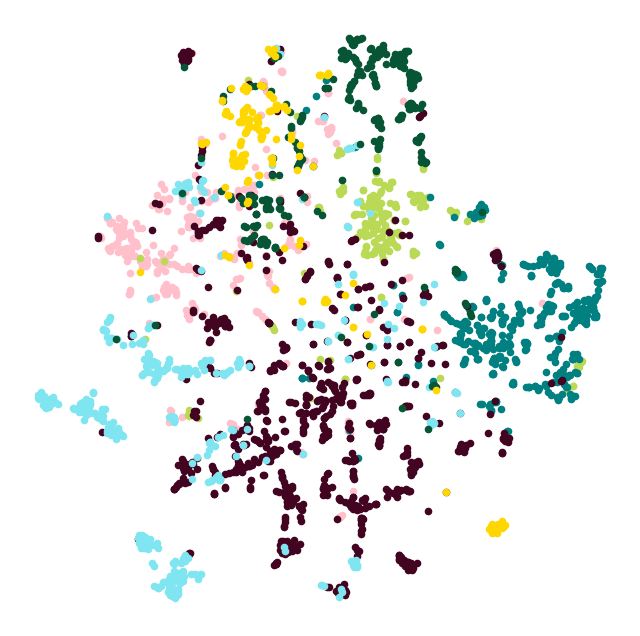

In [9]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)